##1. 분석 준비

In [15]:
!pip install pandas

In [1]:
import pandas as pd
url='https://raw.githubusercontent.com/sehakflower/data/main/titanic.csv'
titanic_df= pd.read_csv(url,sep='\t')

# 컬럼명을 소문자로 바꾸기
new_columns=['passengerId', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
'ticket', 'fare', 'cabin', 'embarked']
titanic_df.columns=new_columns

# 필요한 컬럼만 가져오기
titanic_df1=titanic_df[['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare']]

# 1. sex열을 gender로 바꾸고 여성은 0, 남성은 1로 바꾸기
tmp=[]
for each in titanic_df1['sex']:
  if each=='female':
    tmp.append(0)
  else:
    tmp.append(1)

titanic_df1['gender']=tmp
titanic_df1.drop(columns='sex', inplace=True) # sex 열 삭제하기

# 2. 호칭을 숫자형으로 바꾸기
condition=lambda x: x.split(',')[1].split('.')[0].strip()
titanic_df1['title']=titanic_df1['name'].map(condition) # name에서 호칭만 가져오기
Special=['Master', 'Don', 'Rev'] # 3개 호칭을 title 열의 Special로 대체
for each in Special:
  titanic_df1['title']=titanic_df1['title'].replace(each, 'Special')

titanic_df1=titanic_df1.drop('name', axis=1) # 사용하지 않는 name 열 삭제하기

# 숫자형으로 만드는 함수 만들기
def convert_title(x):
  if x=="Special":
    return 1
  else:
    return 0

titanic_df1["special_title"]=titanic_df1["title"].apply(convert_title)
# special_title 열 만들어서 special은 1, 나머지는 0으로 바꾸기
titanic_df1.drop('title', axis=1, inplace=True) # title 열 삭제하기
# 3. sibpar 열 만들어 동반자 수 더한 값 넣기
titanic_df1['sibpar']=titanic_df1['sibsp']+titanic_df1['parch']
titanic_df1.drop(['sibsp','parch'], axis =1, inplace=True)
# 사용하지 않는 sibsp, parch 열 삭제하기
# 4. avgfare 열 만들어 1인당 평균 탑승 요금 넣기
titanic_df1['avgfare']=titanic_df1['fare']/titanic_df1['sibpar']
titanic_df1['n_family']=titanic_df1['sibpar']+1
# n_family 열 만들어 동반자에 1을 더하여 0으로 나누어지지 않도록 함
titanic_df1['avgfare']=titanic_df1['fare']/titanic_df1['n_family'] # 1인당 평균 탑승 요금
titanic_df1=titanic_df1.drop(['fare','sibpar'], axis=1) # 필요 없는 열 삭제하기
# 5. 최종 분석 데이터 컬럼명만 추출하기
titanic_df1.rename(columns={'gender':'sex', 'special_title':'title', 'avgfare':'fare', 'n_family':'num_family'}, inplace=True) # 컬럼명 변경하기
titanic_df1=titanic_df1[['survived', 'pclass', 'sex', 'age', 'title', 'fare', 'num_family']]
# 컬럼 순서 다시 정하기
titanic_df1=titanic_df1.dropna()
# age에는 NaN 값이 있으므로 이를 삭제한 데이터를 분석에 사용
titanic_df1

C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pc\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\pc\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,survived,pclass,sex,age,title,fare,num_family
0,0,3,1,22.0,0,3.625000,2
1,1,1,0,38.0,0,35.641650,2
2,1,3,0,26.0,0,7.925000,1
3,1,1,0,35.0,0,26.550000,2
4,0,3,1,35.0,0,8.050000,1
...,...,...,...,...,...,...,...
150,0,2,1,51.0,1,12.525000,1
151,1,1,0,22.0,0,33.300000,2
152,0,3,1,55.5,0,8.050000,1
153,0,3,1,40.5,0,4.833333,3


In [2]:
raw=titanic_df1
np_raw=raw.values
type(np_raw)

numpy.ndarray

In [3]:
train=np_raw[:100]
test=np_raw[100:]
y_train = [i[0] for i in train]
X_train = [j[1:] for j in train]
y_test = [i[0] for i in test]
X_test = [j[1:] for j in test]
len(X_train),len(y_train), len(y_test),len(X_test)

(100, 100, 26, 26)

##2. 의사결정나무

In [4]:
!pip3 install -U scikit-learn


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: C:\Python311\python.exe -m pip install --upgrade pip


In [5]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(criterion='entropy',max_depth=3,min_samples_leaf=5).fit(X_train, y_train)
model.fit(X_train, y_train)
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
print('Score:{}'.format(model.score(X_train, y_train)))
print('Score:{}'.format(model.score(X_test, y_test)))

Score:0.84
Score:0.8846153846153846


In [6]:
!pip install graphviz

# 아래 코드가 실행되지 않는다면?

1. 다음 경로에서 파일을 다운받고 설치하면 됩니다.  
https://graphviz.org/download/   
여기서는 graphviz-8.0.5 (64-bit) EXE installer [sha256] 항목을 설치하였다. 

2.아나콘다설치후 주피터노트북을 실행한다면 아나콘다 프롬프트쉘에서 conda install python-graphviz 입력하여 실행한다.

3. 환경변수에서 path도 함께 설정해주어야 합니다.   
(1) 윈도우 검색란에 '환경'이라고 검색하고 Enter를 누르면 시스템 속성 대화상자가 나타난다.  
(2) 하단의 [환경변수] 단추를 클릭하고 상단 목록에서 [path]항목을 선택한후 [편집] 단추를 클릭한다.   
(3) 환경변수 편집 대화상자가 나타나면 [새로 만들기] 단추를 눌러 다음의 두 개의 경로를 추가한후 확인을 클릭한다.     

pc에 대한 사용자 변수창 path변수에 아래를 추가한다.
> C:\Program Files\Graphviz\bin    

시스템 변수창 path에 아래를 추가한다.
> C:\Program Files\Graphviz\bin\dot.exe    

(4) 저장후 주피터 노트북을 재실행한 후 코드를 실행하면 오류 없이 잘 실행되는 것을 확인할수 있다. 

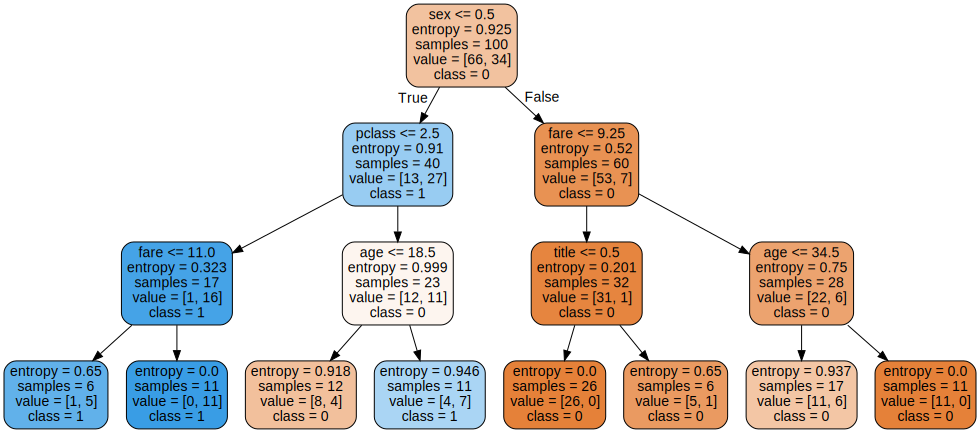

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(
 model,
 out_file="titanic.dot",
 feature_names=['pclass', 'sex', 'age', 'title', 'fare', 'num_family'],
 class_names=['0','1'],
 rounded=True,
 filled=True
)
import graphviz
with open("titanic.dot") as f:
 dot_graph=f.read()
dot=graphviz.Source(dot_graph)
dot.format='png'
dot.render(filename='titanic_tree', directory='image/decision_trees', cleanup=True)
dot

In [8]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test)
print("Test Accuracy is ", accuracy_score(y_test, y_pred)*100)

Test Accuracy is  88.46153846153845


In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[18,  1],
       [ 2,  5]], dtype=int64)

In [10]:
feature_names=['pclass', 'sex', 'age', 'title', 'fare', 'num_family']
Tom=[1,1,33,1,50,4]
Jane=[2,0,50,0,8,1]

In [11]:
model.predict_proba([Tom])

array([[0.64705882, 0.35294118]])

In [12]:
model.predict_proba([Jane])

array([[0.16666667, 0.83333333]])

##3. 로지스틱 회귀분석
### 표준화하지 않은 데이터 이용하기

In [30]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(random_state=13, solver='liblinear', C=10.)
log_reg.fit(X_train, y_train)
LogisticRegression(C=10.0, random_state=13, solver='liblinear')
from sklearn.metrics import accuracy_score
pred=log_reg.predict(X_train)
accuracy_score(y_train, pred)

0.78

In [15]:
pred = log_reg.predict(X_test)
accuracy_score(y_test, pred)

0.8846153846153846

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred)

array([[18,  1],
       [ 2,  5]], dtype=int64)

###표준화한 데이터 이용하기

In [18]:
!pip install seaborn

     ------------------------------------- 293.3/293.3 KB 17.7 MB/s eta 0:00:00


You should consider upgrading via the 'C:\python\python.exe -m pip install --upgrade pip' command.


<AxesSubplot: >

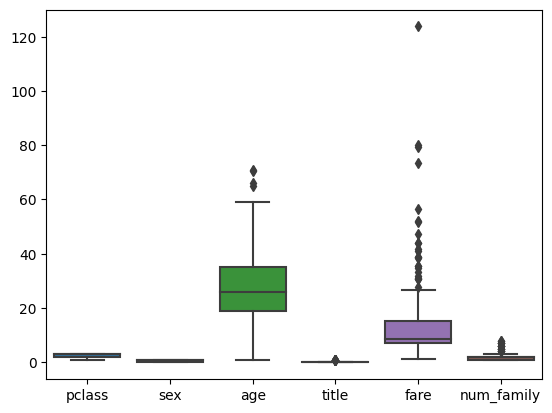

In [19]:
import seaborn as sns
sns.boxplot(data=titanic_df1[['pclass', 'sex', 'age', 'title', 'fare', 'num_family']])

In [21]:
X=titanic_df1
from sklearn.preprocessing import MinMaxScaler, StandardScaler
MMS=MinMaxScaler()
SS=StandardScaler()
SS.fit(X)
MMS.fit(X)
X_ss=SS.transform(X)
X_mms=MMS.transform(X)
X_ss_pd=pd.DataFrame(X_ss, columns=X.columns)
X_mms_pd=pd.DataFrame(X_mms, columns=X.columns)
X_ss_pd.head()

,survived,pclass,sex,age,title,fare,num_family
0,-0.694516,0.814941,0.771321,-0.421929,-0.29361,-0.707577,-0.096803
1,1.439851,-1.659337,-1.296476,0.677291,-0.29361,1.041150,-0.096803
2,1.439851,0.814941,-1.296476,-0.147124,-0.29361,-0.472714,-0.677621
3,1.439851,-1.659337,-1.296476,0.471187,-0.29361,0.544571,-0.096803
4,-0.694516,0.814941,0.771321,0.471187,-0.29361,-0.465886,-0.677621


In [22]:
X_mms_pd.head()

,survived,pclass,sex,age,title,fare,num_family
0,0.0,1.0,1.0,0.301696,0.0,0.020329,0.142857
1,1.0,0.0,0.0,0.529714,0.0,0.281416,0.142857
2,1.0,1.0,0.0,0.358700,0.0,0.055394,0.000000
3,1.0,0.0,0.0,0.486960,0.0,0.207276,0.142857
4,0.0,1.0,1.0,0.486960,0.0,0.056413,0.000000


<AxesSubplot: >

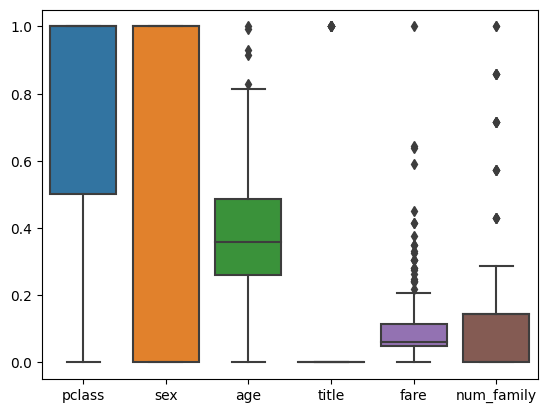

In [23]:
sns.boxplot(data=X_mms_pd[['pclass','sex','age','title','fare','num_family']])

<AxesSubplot: >

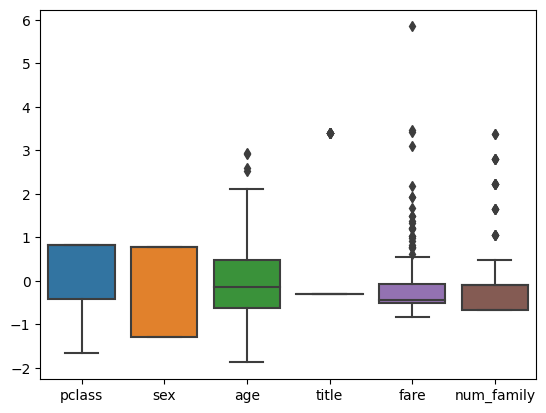

In [24]:
sns.boxplot(data=X_ss_pd[['pclass', 'sex', 'age', 'title', 'fare', 'num_family']])

In [25]:
y=raw['survived']
X=raw.drop(['survived'], axis=1)
X.head()

,pclass,sex,age,title,fare,num_family
0,3,1,22.0,0,3.62500,2
1,1,0,38.0,0,35.64165,2
2,3,0,26.0,0,7.92500,1
3,1,0,35.0,0,26.55000,2
4,3,1,35.0,0,8.05000,1


In [26]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=\
train_test_split(X, y, test_size=0.2, random_state=13)

In [28]:
import numpy as np
np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([66, 34], dtype=int64))

In [29]:
X_out=X_mms_pd
X_train, X_test, y_train, y_test=\
train_test_split(X_out, y, test_size=0.2, random_state=13)

In [30]:
log_reg=LogisticRegression(random_state=13, solver='liblinear', C=10.)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10.0, random_state=13, solver='liblinear')

In [31]:
pred=log_reg.predict(X_test)
accuracy_score(y_test, pred)

1.0

In [32]:
X_out=X_ss_pd
X_train, X_test, y_train, y_test=\
train_test_split(X_out, y, test_size=0.2, random_state=13)
log_reg=LogisticRegression(random_state=13, solver='liblinear', C=10.)
log_reg.fit(X_train, y_train)
pred=log_reg.predict(X_test)
accuracy_score(y_test, pred)

1.0

In [33]:
log_reg.coef_

array([[ 4.73666302e+00, -2.53303155e-01, -5.08052874e-01,
        -1.93453169e-01,  3.13171381e-02,  2.68954893e-03,
        -1.70331998e-01]])